In [33]:
import os
import pandas as pd

In [67]:
eth = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/ETHUSDT_5_data.csv'
btc = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/BTCUSDT_5_data.csv'
sol = f'/Users/gabrielefabietti/projects/fetch_data/data/data4/SOLUSDT_5_data.csv'

df_eth = pd.read_csv(eth)
df_btc = pd.read_csv(btc)
df_sol = pd.read_csv(sol)

In [68]:
df_btc['pct_change_btc'] = (df_btc['close'] - df_btc['open']) / df_btc['open'] * 100
df_sol['pct_change_sol'] = (df_sol['close'] - df_sol['open']) / df_sol['open'] * 100
df_eth['pct_change_eth'] = (df_eth['close'] - df_eth['open']) / df_eth['open'] * 100

In [69]:
df_btc = df_btc.set_index('timestamp')
df_eth = df_eth.set_index('timestamp')
df_sol = df_sol.set_index('timestamp')

In [70]:
combined_df = df_btc['close'].to_frame(name='btc_close')
combined_df = combined_df.join(df_eth['close'].rename('eth_close'))
combined_df = combined_df.join(df_sol['close'].rename('sol_close'))

combined_df.head()

,btc_close,eth_close,sol_close
timestamp,,,
1704063600000,42329.1,2282.75,101.103
1704063900000,42342.4,2284.87,101.725
1704064200000,42273.1,2282.57,100.996
1704064500000,42192.0,2279.09,100.357
1704064800000,42171.3,2278.11,100.483


In [71]:
combined_df = combined_df.join(df_btc['pct_change_btc'])
combined_df = combined_df.join(df_sol['pct_change_sol'])
combined_df = combined_df.join(df_eth['pct_change_eth'])

combined_df.head()

,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth
timestamp,,,,,,
1704063600000,42329.1,2282.75,101.103,0.067138,0.443089,0.307150
1704063900000,42342.4,2284.87,101.725,0.031420,0.615214,0.092870
1704064200000,42273.1,2282.57,100.996,-0.163666,-0.716638,-0.100662
1704064500000,42192.0,2279.09,100.357,-0.191848,-0.632698,-0.152460
1704064800000,42171.3,2278.11,100.483,-0.049061,0.125552,-0.043000


In [72]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134317 entries, 1704063600000 to 1744358400000
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   btc_close       134317 non-null  float64
 1   eth_close       134316 non-null  float64
 2   sol_close       134314 non-null  float64
 3   pct_change_btc  134317 non-null  float64
 4   pct_change_sol  134314 non-null  float64
 5   pct_change_eth  134316 non-null  float64
dtypes: float64(6)
memory usage: 7.2 MB


In [73]:
combined_df['btc_pnl'] = combined_df['pct_change_btc'].shift(1) * (-1) * 100 * combined_df['pct_change_btc']
combined_df['eth_pnl'] = combined_df['pct_change_eth'].shift(1) * (-1) * 100 * combined_df['pct_change_eth']
combined_df['sol_pnl'] = combined_df['pct_change_sol'].shift(1) * (-1) * 100 * combined_df['pct_change_sol']

In [74]:
combined_df.head(25)

,btc_close,eth_close,sol_close,pct_change_btc,pct_change_sol,pct_change_eth,btc_pnl,eth_pnl,sol_pnl
timestamp,,,,,,,,,
1704063600000,42329.1,2282.75,101.103,0.067138,0.443089,0.307150,NaN,NaN,NaN
1704063900000,42342.4,2284.87,101.725,0.031420,0.615214,0.092870,-0.210952,-2.852517,-27.259458
1704064200000,42273.1,2282.57,100.996,-0.163666,-0.716638,-0.100662,0.514245,0.934854,44.088586
1704064500000,42192.0,2279.09,100.357,-0.191848,-0.632698,-0.152460,-3.139891,-1.534693,-45.341566
1704064800000,42171.3,2278.11,100.483,-0.049061,0.125552,-0.043000,-0.941233,-0.655571,7.943640
1704065100000,42221.4,2279.01,100.824,0.118801,0.339361,0.039506,0.582856,0.169876,-4.260736
1704065400000,42268.9,2281.57,101.177,0.112502,0.350115,0.112329,-1.336539,-0.443774,-11.881535
1704065700000,42274.0,2281.25,101.131,0.012066,-0.045465,-0.014025,-0.135741,0.157547,1.591794
1704066000000,42285.2,2281.93,101.303,0.026494,0.170076,0.029808,-0.031966,0.041807,0.773250


In [75]:
pnl_sol = combined_df['sol_pnl'].sum()
pnl_btc = combined_df['btc_pnl'].sum()
pnl_eth = combined_df['eth_pnl'].sum()

print(pnl_sol)
print(pnl_eth)
print(pnl_btc)

42543.02584128067
6077.847767248029
6683.410379463135


In [76]:
combined_df['tot_pnl'] = combined_df['btc_pnl'] + combined_df['eth_pnl'] +combined_df['sol_pnl']

In [77]:
combined_df['account_pnl'] = combined_df['tot_pnl'].cumsum()

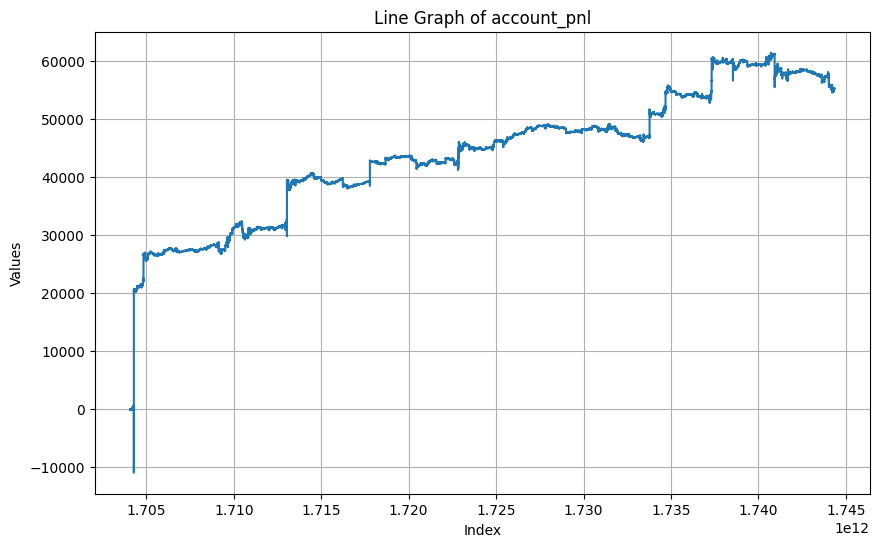

In [78]:
import matplotlib.pyplot as plt

# Create a simple line plot
plt.figure(figsize=(10, 6))
plt.plot(combined_df['account_pnl'])
plt.title('Line Graph of account_pnl')
plt.xlabel('Index')
plt.ylabel('Values')
plt.grid(True)
plt.show()

In [79]:
# This gives you count, mean, std, min, 25%, 50%, 75%, max
stats = combined_df['tot_pnl'].describe()
print(stats)

count    134313.000000
mean          0.411803
std         102.077541
min      -10826.872198
25%          -2.572111
50%           0.038022
75%           2.799775
max       31547.556635
Name: tot_pnl, dtype: float64
